<a href="https://colab.research.google.com/github/jberardini2/PySpark/blob/main/PySpark_and_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* **This document demonstrates Setting up PySpark, executing PySpark queries, creating a PySpark Logistic Regression model, and also intrepreting the confusion matrix and classification report.**

## Utilize Spark's Machine Learning Library to build classification models for prediction.

A few key concepts that we will revisit in this walk-through are:

1. Apply String Indexer method to find the index of the categorical columns

2. Apply OneHot encoding for the categorical columns

3. Apply String indexer for the output variable “label” column

4. VectorAssembler is applied for both categorical columns and numeric columns. VectorAssembler is a transformer that combines a given list of columns into a single vector column.

### **Step 1**: Install Spark and use existing Java in Colab environment

In [1]:
import os as os


In [2]:
# Using existing Java provided by Colab -  Curently, /usr/lib/jvm/java-11-openjdk-amd64
# !sudo apt update

# Download and install Java if needed.
#!sudo apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
# Current default directory from Colab.  THe Spark installation file will go here:
os. getcwd()

'/content'

In [4]:
# Install Apache Spark 3.2.4 with Hadoop 3.2 within the Colab environment:
!wget -nc -q https://downloads.apache.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz

In [5]:
# Unzip the folder
!tar xf  spark-3.2.4-bin-hadoop3.2.tgz

In [6]:
# Install findspark library that will locate Spark on the system
!pip install -q findspark

In [7]:
# Setting the environment variables - verify the paths are correct in Colab: ( Periodically, a new version path will need to update environment variable.)
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop3.2"

In [8]:
import findspark
findspark.init()

In [9]:
# Create a Spark Session
from pyspark.sql import SparkSession

# Create spark session
spark = SparkSession.builder.getOrCreate()

In [10]:
sc = spark.sparkContext

### **Step 2**: Read in Data from Google Drive

In [11]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# df = spark.read.csv(SparkFiles.get("adult_data.csv"), header=True, inferSchema= True)
df = spark.read.option("header", "true").csv("/content/drive/My Drive/Education/Big Data/adult.csv")

### **Step 3**: Using SQL to interface with Spark

In [13]:
df.printSchema()

root
 |-- x: string (nullable = true)
 |-- age: string (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: string (nullable = true)
 |-- education: string (nullable = true)
 |-- educationalNum: string (nullable = true)
 |-- maritalStatus: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capitalGain: string (nullable = true)
 |-- capitalLoss: string (nullable = true)
 |-- hoursPerWeek: string (nullable = true)
 |-- nativeCountry: string (nullable = true)
 |-- income: string (nullable = true)



In [14]:
df.show()

+---+---+----------------+------+------------+--------------+------------------+-----------------+-------------+------------------+------+-----------+-----------+------------+-------------+------+
|  x|age|       workclass|fnlwgt|   education|educationalNum|     maritalStatus|       occupation| relationship|              race|gender|capitalGain|capitalLoss|hoursPerWeek|nativeCountry|income|
+---+---+----------------+------+------------+--------------+------------------+-----------------+-------------+------------------+------+-----------+-----------+------------+-------------+------+
|  1| 25|         Private|226802|        11th|             7|     Never-married|Machine-op-inspct|    Own-child|             Black|  Male|          0|          0|          40|United-States| <=50K|
|  2| 38|         Private| 89814|     HS-grad|             9|Married-civ-spouse|  Farming-fishing|      Husband|             White|  Male|          0|          0|          50|United-States| <=50K|
|  3| 28|      

### **Step 4**: Create a temporary view and query with SQL commands.

In [15]:
# Creating a view for SQL commands called Adult Data.
df.createOrReplaceTempView("adultView")

In [16]:
# Select all where education contains college:
sqlDF = spark.sql("SELECT * FROM adultView WHERE education like '%college%' ")
sqlDF.show()

+---+---+----------------+------+------------+--------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+------------------+------+
|  x|age|       workclass|fnlwgt|   education|educationalNum|     maritalStatus|       occupation| relationship| race|gender|capitalGain|capitalLoss|hoursPerWeek|     nativeCountry|income|
+---+---+----------------+------+------------+--------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+------------------+------+
|  4| 44|         Private|160323|Some-college|            10|Married-civ-spouse|Machine-op-inspct|      Husband|Black|  Male|       7688|          0|          40|     United-States|  >50K|
|  5| 18|               ?|103497|Some-college|            10|     Never-married|                ?|    Own-child|White|Female|          0|          0|          30|     United-States| <=50K|
|  9| 24|         Private|369667|Some-college|         

In [17]:
print (type(sqlDF))

<class 'pyspark.sql.dataframe.DataFrame'>


In [18]:
# Filter the data frame so that only records where the hours-per-week is greater than 30.

In [19]:
df.printSchema()

root
 |-- x: string (nullable = true)
 |-- age: string (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: string (nullable = true)
 |-- education: string (nullable = true)
 |-- educationalNum: string (nullable = true)
 |-- maritalStatus: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capitalGain: string (nullable = true)
 |-- capitalLoss: string (nullable = true)
 |-- hoursPerWeek: string (nullable = true)
 |-- nativeCountry: string (nullable = true)
 |-- income: string (nullable = true)



In [20]:

# Refine further by selecting where hours per week is greater than 30:
sqlDF.filter("hoursPerWeek > 30").show()

+---+---+----------------+------+------------+--------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+------------------+------+
|  x|age|       workclass|fnlwgt|   education|educationalNum|     maritalStatus|       occupation| relationship| race|gender|capitalGain|capitalLoss|hoursPerWeek|     nativeCountry|income|
+---+---+----------------+------+------------+--------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+------------------+------+
|  4| 44|         Private|160323|Some-college|            10|Married-civ-spouse|Machine-op-inspct|      Husband|Black|  Male|       7688|          0|          40|     United-States|  >50K|
|  9| 24|         Private|369667|Some-college|            10|     Never-married|    Other-service|    Unmarried|White|Female|          0|          0|          40|     United-States| <=50K|
| 22| 34|         Private|238588|Some-college|         

In [21]:
# Cast
sqlDF = sqlDF.withColumn("hoursPerWeek", sqlDF.hoursPerWeek.cast('Float'))

In [22]:
sqlDF.printSchema()

root
 |-- x: string (nullable = true)
 |-- age: string (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: string (nullable = true)
 |-- education: string (nullable = true)
 |-- educationalNum: string (nullable = true)
 |-- maritalStatus: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capitalGain: string (nullable = true)
 |-- capitalLoss: string (nullable = true)
 |-- hoursPerWeek: float (nullable = true)
 |-- nativeCountry: string (nullable = true)
 |-- income: string (nullable = true)



In [23]:
# Display average hours per week for each work class:
sqlDF.groupBy("workclass").avg("hoursPerWeek").show()

+----------------+------------------+
|       workclass| avg(hoursPerWeek)|
+----------------+------------------+
|Self-emp-not-inc|44.255524861878456|
|       Local-gov|  40.3106960950764|
|       State-gov| 35.30408163265306|
|         Private| 38.78699402786994|
|     Without-pay|35.333333333333336|
|     Federal-gov| 40.23691460055097|
|    Never-worked|              22.0|
|               ?|31.557142857142857|
|    Self-emp-inc| 48.71987951807229|
+----------------+------------------+



In [24]:
# Reviewing our dependent variable that we will be trying to predict.
# Select all where education contains college:
sqlDF_counts = spark.sql("SELECT COUNT(DISTINCT income) FROM adultView")
sqlDF_counts.show()

+----------------------+
|count(DISTINCT income)|
+----------------------+
|                     2|
+----------------------+



In [25]:
# Select all where education contains college:
sqlDF_counts = spark.sql("SELECT COUNT(income) FROM adultView WHERE income = '>50K'")
sqlDF_counts.show()

+-------------+
|count(income)|
+-------------+
|        11687|
+-------------+



In [26]:
# Select all where education contains college:
sqlDF_counts = spark.sql("SELECT COUNT(income) FROM adultView WHERE income = '<=50K'")
sqlDF_counts.show()

+-------------+
|count(income)|
+-------------+
|        37155|
+-------------+



In [27]:
# Import PySpark Fuctions for querying.
import pyspark.sql.functions as functions

# Standard deviation of hours per week by workclass.
sqlDF.groupBy("workclass").agg(functions.stddev("hoursPerWeek")).show()

+----------------+-------------------------+
|       workclass|stddev_samp(hoursPerWeek)|
+----------------+-------------------------+
|Self-emp-not-inc|       16.895240145027948|
|       Local-gov|        11.48350951761517|
|       State-gov|       13.648650789648785|
|         Private|       11.740610430937776|
|     Without-pay|       26.083200212652844|
|     Federal-gov|        8.954091836683306|
|    Never-worked|        25.45584412271571|
|               ?|       13.618996458352091|
|    Self-emp-inc|       14.946121645808361|
+----------------+-------------------------+



## Prepare data for Logistic Regression Model

In [28]:
# This is a function to convert dataframe columns to the appropriate data type.
def convertColumn(df, names, newType):
  for name in names:
     df = df.withColumn(name, df[name].cast(newType))
  return df

In [29]:
# Assign all floats to `columns`.
columns = ['age', 'fnlwgt','capitalGain', 'educationalNum', 'capitalLoss', 'hoursPerWeek']

### **Step 5**: Convert the data types of the above mentioned columns into a float type

In [30]:
from pyspark.sql.types import *
# Conver the `df` columns to `FloatType()`
df = convertColumn(df, columns, FloatType())

### **Step 6**: Confirm that the data type has been converted into float

In [31]:
df.dtypes

[('x', 'string'),
 ('age', 'float'),
 ('workclass', 'string'),
 ('fnlwgt', 'float'),
 ('education', 'string'),
 ('educationalNum', 'float'),
 ('maritalStatus', 'string'),
 ('occupation', 'string'),
 ('relationship', 'string'),
 ('race', 'string'),
 ('gender', 'string'),
 ('capitalGain', 'float'),
 ('capitalLoss', 'float'),
 ('hoursPerWeek', 'float'),
 ('nativeCountry', 'string'),
 ('income', 'string')]

### **Step 7**: Drop rows that have a '?' in them



In [32]:
import numpy as np
df = df.replace("?", "np.Nan")

# Remove missing value
df = df.filter("workclass != 'np.Nan'").filter("occupation != 'np.Nan'").filter("`nativeCountry` != 'np.Nan'")
df.show()

+---+----+----------------+--------+------------+--------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
|  x| age|       workclass|  fnlwgt|   education|educationalNum|     maritalStatus|       occupation| relationship| race|gender|capitalGain|capitalLoss|hoursPerWeek|nativeCountry|income|
+---+----+----------------+--------+------------+--------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
|  1|25.0|         Private|226802.0|        11th|           7.0|     Never-married|Machine-op-inspct|    Own-child|Black|  Male|        0.0|        0.0|        40.0|United-States| <=50K|
|  2|38.0|         Private| 89814.0|     HS-grad|           9.0|Married-civ-spouse|  Farming-fishing|      Husband|White|  Male|        0.0|        0.0|        50.0|United-States| <=50K|
|  3|28.0|       Local-gov|336951.0|  Assoc-acdm|          12.0|M

### **Step 8:** Use "StringIndexer" and "OneHotEncoding" to convert categorical features into numeric values

In [33]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

#Store all the categorical columns
categorical_Cols = ['workclass', 'education', 'maritalStatus', 'occupation', 'relationship', 'race', 'gender', 'nativeCountry']
pipeline_stages = []

#Iterate throughthe categorical columns
for categoricalCol in categorical_Cols :
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "_conv"])
    pipeline_stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
#Add another stage to the ML pipeline
pipeline_stages += [label_stringIdx]

#Store all the numeric columns
numericCols = ['age', 'fnlwgt', 'capitalGain', 'capitalLoss', 'hoursPerWeek']
assembler_Inputs = [c + "_conv" for c in categorical_Cols] + numericCols
assembler = VectorAssembler(inputCols=assembler_Inputs, outputCol="features")
pipeline_stages += [assembler]

### **Step 9**: We use the ML Pipeline to chain multiple Transformers and Estimators together to create the maachine learning workflow.

In [34]:
from pyspark.ml import Pipeline

ml_pipe = Pipeline(stages = pipeline_stages)
# Fit and transform the data
pipe_data = ml_pipe.fit(df).transform(df)
selectedCols = ['label', 'features'] + df.columns
df = pipe_data.select(selectedCols)
df.show()

+-----+--------------------+---+----+----------------+--------+------------+--------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
|label|            features|  x| age|       workclass|  fnlwgt|   education|educationalNum|     maritalStatus|       occupation| relationship| race|gender|capitalGain|capitalLoss|hoursPerWeek|nativeCountry|income|
+-----+--------------------+---+----+----------------+--------+------------+--------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
|  0.0|(95,[0,11,22,33,4...|  1|25.0|         Private|226802.0|        11th|           7.0|     Never-married|Machine-op-inspct|    Own-child|Black|  Male|        0.0|        0.0|        40.0|United-States| <=50K|
|  0.0|(95,[0,6,21,36,40...|  2|38.0|         Private| 89814.0|     HS-grad|           9.0|Married-civ-spouse|  Farming-fishing|      Husband|Wh

### **Step 10:** Split the data set into Train and Test data sets respectively

In [35]:
train, test = df.randomSplit([0.7, 0.3], seed = 12345)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 31545
Test Dataset Count: 13677


### **Step 11**: Create a Logistic Regression Model

In [36]:
# Import `LinearRegression`
from pyspark.ml.classification import LogisticRegression

# Initialize `lr`
lr = LogisticRegression(labelCol="label",
                        featuresCol="features",
                        maxIter=10,
                        regParam=0.3)

# Fit the data to the model
linearModel = lr.fit(train)

### **Step 12**: Make predictions on test data using the transform() method.


In [37]:
predictions = linearModel.transform(test)

### **Step 13**: Examine the elements in predictions object

In [38]:
predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- x: string (nullable = true)
 |-- age: float (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: float (nullable = true)
 |-- education: string (nullable = true)
 |-- educationalNum: float (nullable = true)
 |-- maritalStatus: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capitalGain: float (nullable = true)
 |-- capitalLoss: float (nullable = true)
 |-- hoursPerWeek: float (nullable = true)
 |-- nativeCountry: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



### **Step 14**: Investigate the predictions

In [39]:
predictions.select( 'label', 'rawPrediction', 'prediction', 'probability').show(50)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[0.86870439450838...|       0.0|[0.70447603795007...|
|  0.0|[0.87205298562233...|       0.0|[0.70517270196544...|
|  0.0|[0.50974157579245...|       0.0|[0.62474589184790...|
|  0.0|[0.73040941057940...|       0.0|[0.67489510848530...|
|  0.0|[0.77311698834401...|       0.0|[0.68419477488161...|
|  0.0|[0.64718007958056...|       0.0|[0.65637471899290...|
|  0.0|[0.69283267526089...|       0.0|[0.66659677293712...|
|  0.0|[0.43145902500777...|       0.0|[0.60622201625957...|
|  0.0|[0.22483821111194...|       0.0|[0.55597395058242...|
|  0.0|[1.08790862076715...|       0.0|[0.74798769672425...|
|  0.0|[1.14855316103718...|       0.0|[0.75924654668656...|
|  0.0|[1.04917533488512...|       0.0|[0.74061650940406...|
|  0.0|[1.02690321384842...|       0.0|[0.73631507891832...|
|  0.0|[1.02756591265401

### **Step 15**: Evaluate the predictions

**Evaluating the Model** - Since the Logistic model at hand is a binary classification model (given that the outcome is 1 or 0), the BinaryClassificationEvaluator from the ***pyspark.ml.evaluation*** module will be utilized to evaluate the Logistic Regression Model.

The BinaryClassificationEvaluator calculates the area under the ROC which is is one of the most important evaluation metrics for checking any classification model’s performance. It finds the best model by maximizing the model evaluation metric that is the area under the specified curve. The closer the area Under Curve is to one (1), the better the model is!

For more details, check out: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5


In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label",metricName="areaUnderROC")

# Evaluate the predictions
print("The area under ROC for test data set is {}".format(evaluator.evaluate(predictions)))

The area under ROC for test data set is 0.8847519740170927


In [41]:
# Found code to display ROC Curve here: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve

from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/content/spark-3.2.4-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


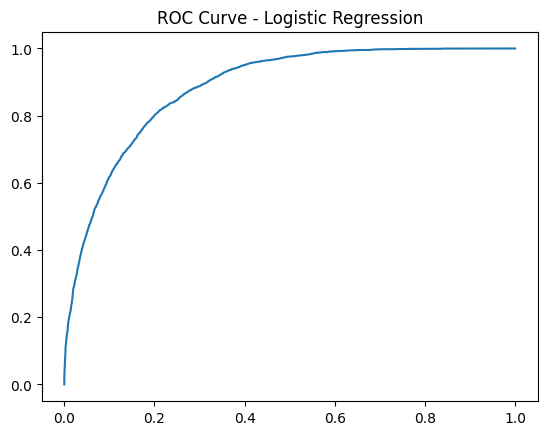

In [42]:
import matplotlib.pyplot as plt


# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC Curve - Logistic Regression")
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.plot(x_val, y_val)

### Create Confusion Matrix with PySpark:


In [43]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [44]:
#select only prediction and label columns
preds_and_labels = predictions.select(['prediction','label'])

In [45]:
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))


/content/spark-3.2.4-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


* True Positive, False Positive
* False Negative, True Negative

In [46]:
# Accuracy Score (TP + TN / All)
print (metrics.accuracy)

0.8125319880090663


In [47]:
print(metrics.confusionMatrix().toArray())

[[10022.   271.]
 [ 2293.  1091.]]


In [48]:
# printing
import sklearn

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.97      0.89     10293
         1.0       0.80      0.32      0.46      3384

    accuracy                           0.81     13677
   macro avg       0.81      0.65      0.67     13677
weighted avg       0.81      0.81      0.78     13677



* **Precision**: Out of all the workers that the model predicted a salary > 50k, 80% actually did have a salary > 50k.

* **Recall**: Out of all the workers with an actual salary > 50k,  the model only predicted this outcome correctly for 32% of those workers.

* **F1-Score**: Overall, the model does a poor job of predicting if someone is making more than 50k.

In [49]:
sklearn.metrics.precision_score(y_true, y_pred)

0.8010279001468429

In [50]:
sklearn.metrics.recall_score(y_true, y_pred)

0.32239952718676124

In [51]:
sklearn.metrics.median_absolute_error(y_true, y_pred)

0.0